In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/objectdetection")

# Lib

## augmentations.py

In [5]:
import cv2
import numpy as np
import random

from lib.utils import bbox_iou


def _crop(image, boxes, labels):
    height, width, _ = image.shape
    
    if len(boxes) == 0:
        return image, boxes, labels

    while True:
        mode = random.choice(( 
            None,
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            (None, None),
        ))
        
        if mode is None:
            return image, boxes, labels
        
        min_iou, max_iou = mode
        # min_iou나 max_iou가 None이면 -inf, inf로 설정
        if min_iou is None:
            min_iou = float('-inf')
        if max_iou is None:
            max_iou = float('inf')

        for _ in range(50):
            w = random.randrange(int(0.3 * width), width) # 0.3*width~width 범위 내에서 랜덤하게 w 설정
            h = random.randrange(int(0.3 * height), height) # 0.3*height~height 범위 내에서 랜덤하게 h 설정
            
            # h,w가 2배 이상 차이나면 다음 step으로 넘어감
            if h / w < 0.5 or 2 < h / w: 
                continue

                
            l = random.randrange(width - w)
            t = random.randrange(height - h)
            roi = np.array((l, t, l + w, t + h)) # xmin, ymin, xmax, ymax

            # 실제 box와 roi의 iou 계산, np.newaxis는 차원을 늘려줌
            iou = bbox_iou(boxes, roi[np.newaxis]) 
            # min_iou보다 작거나 max_iou보다 크면 다음 step
            if not (min_iou <= iou.min() and iou.max() <= max_iou):
                continue
            
            # 새로운 image 영역
            image = image[roi[1]:roi[3], roi[0]:roi[2]]
        
            # xmin, ymin이 centers보다 작고, xmax, ymax가 centers보다 큰 (올바른) boxes와 labels만 추출
            centers = (boxes[:, :2] + boxes[:, 2:]) / 2
            mask = np.logical_and(roi[:2] < centers, centers < roi[2:]) \
                     .all(axis=1) # np.logical_and는 둘 다 True일 때만 True
            boxes = boxes[mask].copy()
            labels = labels[mask]
            
            # boxes 좌표 재설정
            boxes[:, :2] = np.maximum(boxes[:, :2], roi[:2])
            boxes[:, :2] -= roi[:2]
            boxes[:, 2:] = np.minimum(boxes[:, 2:], roi[2:])
            boxes[:, 2:] -= roi[:2]

            return image, boxes, labels


def _distort(image):
    def _convert(image, alpha=1, beta=0):
        tmp = image.astype(float) * alpha + beta
        tmp[tmp < 0] = 0 #음수면 0으로 대체
        tmp[tmp > 255] = 255 #255가 넘으면 255로 대체
        image[:] = tmp

    image = image.copy()
    
    # 픽셀값 조정
    if random.randrange(2): #0 or 1이므로 50%의 확률
        _convert(image, beta=random.uniform(-32, 32))

    if random.randrange(2):
        _convert(image, alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #HSV로 변환

    # 밝기 조정
    if random.randrange(2):
        tmp = image[:, :, 0].astype(int) + random.randint(-18, 18)
        tmp %= 180
        image[:, :, 0] = tmp

    if random.randrange(2):
        _convert(image[:, :, 1], alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


# 크기를 확장시켜 비는 공간은 fill 값으로 채워줌
def _expand(image, boxes, fill):
    if random.randrange(2):
        return image, boxes

    height, width, depth = image.shape
    ratio = random.uniform(1, 4)
    left = random.randint(0, int(width * ratio) - width)
    top = random.randint(0, int(height * ratio) - height)

    expand_image = np.empty(
        (int(height * ratio), int(width * ratio), depth),
        dtype=image.dtype)
    expand_image[:, :] = fill
    expand_image[top:top + height, left:left + width] = image
    image = expand_image

    boxes = boxes.copy()
    boxes[:, :2] += (left, top)
    boxes[:, 2:] += (left, top)

    return image, boxes


def _mirror(image, boxes):
    _, width, _ = image.shape
    if random.randrange(2):
        image = image[:, ::-1] # [::-1] 리스트 값들 역순으로 출력
        boxes = boxes.copy()
        boxes[:, 0::2] = width - boxes[:, 2::-2] # [2::-2] index 2부터 역순으로 한 칸 건너 띄어 출력 
    return image, boxes


def preproc_for_test(image, insize, mean):
    image = cv2.resize(image, (insize, insize))
    image = image.astype(np.float32)
    image -= mean
    return image.transpose(2, 0, 1) #BGR에서 RGB 형태로 변환


def preproc_for_train(image, boxes, labels, insize, mean):
    if len(boxes) == 0:
        boxes = np.empty((0, 4))

    image, boxes, labels = _crop(image, boxes, labels)
    image = _distort(image)
    image, boxes = _expand(image, boxes, mean)
    image, boxes = _mirror(image, boxes)

    height, width, _ = image.shape
    image = preproc_for_test(image, insize, mean)
    boxes = boxes.copy()
    boxes[:, 0::2] /= width
    boxes[:, 1::2] /= height

    return image, boxes, labels


## model.py

In [3]:
models.vgg16().features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import models
import torch.nn.functional as F
import torch.nn.init as init



class L2Norm(nn.Module):

    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma = scale or None
        self.eps = 1e-10
        self.weight = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)
        

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps
        x = torch.div(x, norm)
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return x


def VGG():
    base_vgg = models.vgg16().features
    base_vgg[16].ceil_mode = True # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    vgg = []
    for i in range(30):
        vgg.append(base_vgg[i])

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    vgg += [pool5, conv6,nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return vgg


def Extra():
    layers = []
    conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1)
    conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
    conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1)
    conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
    conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1)
    conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
    conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)

    layers = [conv8_1, conv8_2, conv9_1, conv9_2, conv10_1, conv10_2, conv11_1, conv11_2]

    return layers


def Feature_extractor(vgg, extral, bboxes, num_classes):

    loc_layers = []
    conf_layers = []
    vgg_useful = [21, 33] # 사용할 vgg conv 선택. 21 : 512-512 conv, 33 : 1024-1024 conv
    
    for k, v in enumerate(vgg_useful):
        loc_layers += [nn.Conv2d(vgg[v].out_channels, # 512, 1024 -> 38, 19 (이미지 사이즈가 300일 경우)
                                 bboxes[k] * 4, kernel_size=3, padding=1)]
                                # anchor * 4개의 값을 갖게 하기 위해서(좌표) -> bounding box의 개수 * 4
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        bboxes[k] * num_classes, kernel_size=3, padding=1)]
                                # bounding box의 개수 * num_classes
            
    for k, v in enumerate(extral[1::2], 2): # k는 2부터 시작, v에는 짝수 conv층만
        loc_layers += [nn.Conv2d(v.out_channels, bboxes[k] # 512, 256, 256, 256 -> 10, 5, 3, 1 (feature map)
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, bboxes[k]
                                  * num_classes, kernel_size=3, padding=1)]
        
    
    
    return loc_layers, conf_layers 




class SSD(nn.Module):

    def __init__(self, num_classes, bboxes):
        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.bboxes = bboxes 

        self.vgg_list = VGG()
        self.extra_list = Extra()

        self.loc_layers_list, self.conf_layers_list = Feature_extractor(self.vgg_list, self.extra_list, self.bboxes, self.num_classes)

        self.L2Norm = L2Norm(512, 20)


        self.vgg = nn.ModuleList(self.vgg_list)
        self.extras = nn.ModuleList(self.extra_list)
        self.loc = nn.ModuleList(self.loc_layers_list)
        self.conf = nn.ModuleList(self.conf_layers_list)


    def forward(self, x):

        source = []
        loc = []
        conf = []
        
        # vgg_source(22, 34)번째 layer의 경우, layer의 output을 source에 append (21은 L2norm해주기)
        vgg_source = [22, 34]
        for i, v in enumerate(self.vgg):
            x = v(x)

            if i in vgg_source:
                if i == 22:
                    s = self.L2Norm(x)
                else:
                    s = x
                source.append(s)

        for i, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if i % 2 == 1: # 홀수 layer의 결과만 source에 추가
                source.append(x)


        for s, l, c in zip(source, self.loc, self.conf):
            loc.append(l(s).permute(0, 2, 3, 1).contiguous())
            conf.append(c(s).permute(0, 2, 3, 1).contiguous())
            # tensor가 contiguous하면 x[0][0]과 x[0][1]이 메모리 공간 상에서
            # 이웃해있다
            # transpose, permute 사용 시 실제 데이터의 위치는 
            # 그대로이므로 continuous로 위치를 변경해준다

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        return loc, conf



if __name__ == '__main__':

    x = torch.randn(1, 3, 300, 300) 
    ssd = SSD(21, [4,6,6,6,4,4])

    y = ssd(x)
    print(y[0].shape, y[1].shape)

torch.Size([1, 8732, 4]) torch.Size([1, 8732, 21])


## utils.py

In [6]:
import numpy as np
import torch
import cv2

# (x center, y center, h, w) -> (xmin, ymin, xmax, ymax)
def point_form(boxes):

    tl = boxes[:, :2] - boxes[:, 2:]/2
    br = boxes[:, :2] + boxes[:, 2:]/2

    return np.concatenate([tl, br], axis=1)


def detection_collate(batch):

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(sample[1])
    return torch.stack(imgs), np.array(targets)


# IOU 계산
def bbox_iou(box_a, box_b):

    m = box_a.shape[0]
    n = box_b.shape[0]

    tl = np.maximum(box_a[:, None, :2], box_b[None, :, :2])
    br = np.minimum(box_a[:, None, 2:], box_b[None, :, 2:])

    wh = np.maximum(br-tl, 0)
    
    inner = wh[:, :, 0]*wh[:, :, 1]

    a = box_a[:, 2:] - box_a[:, :2]
    b = box_b[:, 2:] - box_b[:, :2]

    a = a[:, 0] * a[:, 1]
    b = b[:, 0] * b[:, 1]

    a = a[:, None]
    b = b[None, :]

    return inner / (a+b-inner)


def nms(boxes, score, threshold=0.4):

    sort_ids = np.argsort(score) # score 오름차순으로 index값 저장
    pick = []
    # score가 높은 것부터 순서대로 pick에 넣음
    while len(sort_ids) > 0: 
        i = sort_ids[-1] 
        pick.append(i)
        if len(sort_ids) == 1:
            break

        sort_ids = sort_ids[:-1]
        box = boxes[i].reshape(1, 4)
        ious = bbox_iou(box, boxes[sort_ids]).reshape(-1)

        sort_ids = np.delete(sort_ids, np.where(ious > threshold)[0])

    return pick




def detect(locations, scores, nms_threshold, gt_threshold):

    scores = scores[:, 1:] 

    keep_boxes = []
    keep_confs = []
    keep_labels = []

    for i in range(scores.shape[1]):
        
        # score가 임계값 이상인 것들만 추출
        mask = scores[:, i] >= gt_threshold
        label_scores = scores[mask, i] 
        label_boxes = locations[mask]
        
        # 임계값 이상인 것이 없으면 다음 step
        if len(label_scores) == 0:
            continue
        
        # iou가 임계값 이상인 것들만 추출
        pick = nms(label_boxes, label_scores, threshold=nms_threshold)
        label_scores = label_scores[pick]
        label_boxes = label_boxes[pick]
        

        keep_boxes.append(label_boxes.reshape(-1))
        keep_confs.append(label_scores)
        keep_labels.extend([i]*len(label_scores))

    if len(keep_boxes) == 0:
        return np.array([]), np.array([]), np.array([])
        
    
    keep_boxes = np.concatenate(keep_boxes, axis=0).reshape(-1, 4)

    keep_confs = np.concatenate(keep_confs, axis=0)
    keep_labels = np.array(keep_labels).reshape(-1)

    return keep_boxes, keep_confs, keep_labels




# bbox 및 텍스트 그리기
def draw_rectangle(src_img, labels, conf, locations, label_map):

    num_obj = len(labels)
    COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    img = src_img.copy()
    for i in range(num_obj):
        tl = tuple(locations[i][:2])
        br = tuple(locations[i][2:])
        
        cv2.rectangle(img,
                      tl,
                      br,
                      COLORS[i%3], 3)
        cv2.putText(img, label_map[labels[i]], tl,
                    FONT, 1, (255, 255, 255), 2)
    
    img = img[:, :, ::-1]

    return img

## multibox_encoder.py


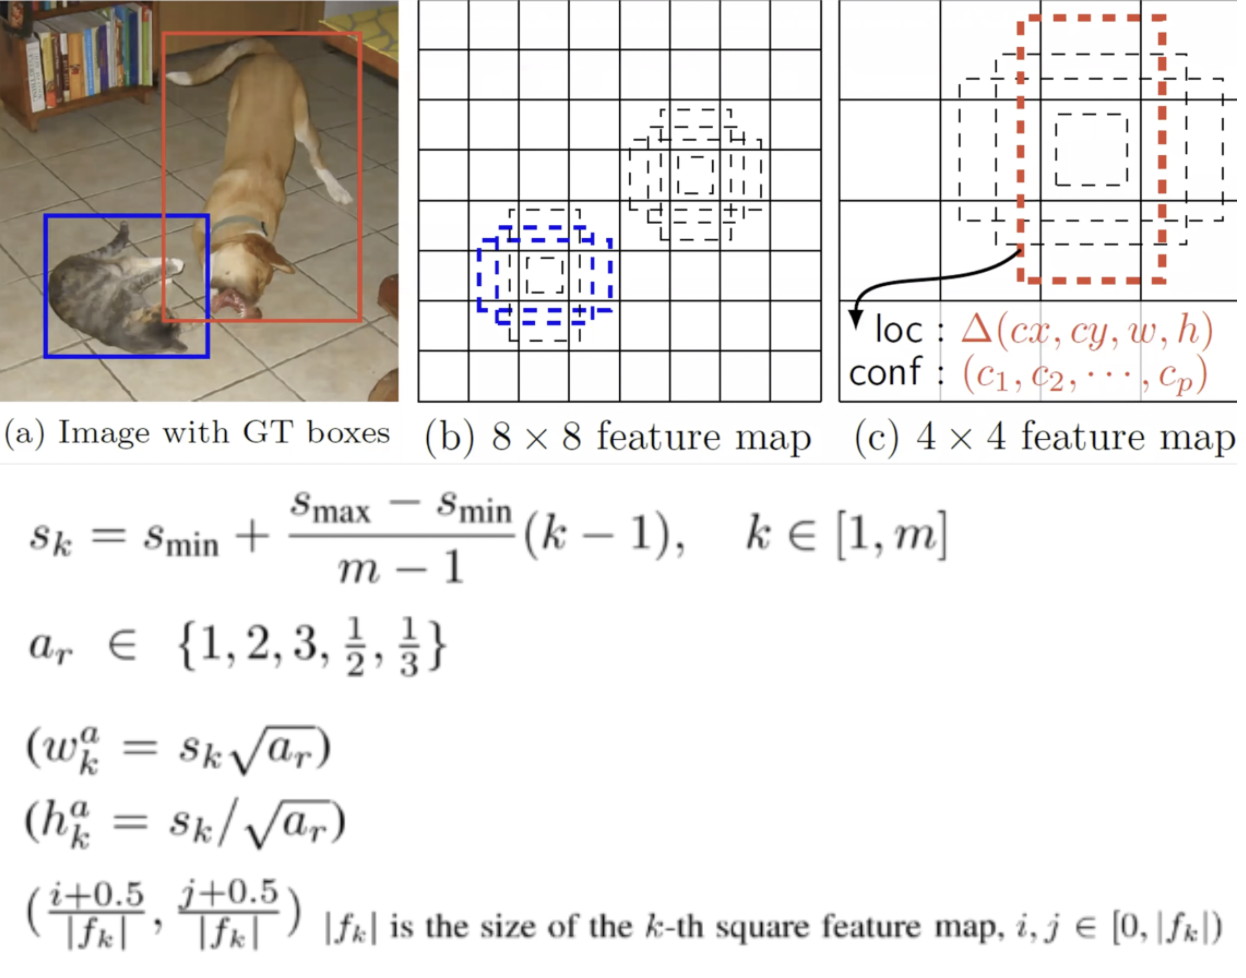

In [8]:
import itertools
import numpy as np

from lib.utils import bbox_iou
from lib.utils import point_form

class MultiBoxEncoder(object):

    def __init__(self, opt):
        self.variance = opt.variance

        default_boxes = list()
        
        # opt.grids = (38, 19, 10, 5, 3, 1)
        
        # opt.steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]           
        # [0.02666666666666667, 0.05333333333333334, 0.10666666666666667, 
        # 0.21333333333333335, 0.3333333333333333, 1.0]
        
        
        # opt.sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)]   
        # [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
        for k in range(len(opt.grids)):
        
            for v, u in itertools.product(range(opt.grids[k]), repeat=2):
                cx = (u + 0.5) * opt.steps[k]
                cy = (v + 0.5) * opt.steps[k]
                # 3x3 feature map의 opt.steps는 1/3이므로 3을 곱해주는 셈
                
                # 1:1 비율의 default box
                s = opt.sizes[k]
                default_boxes.append((cx, cy, s, s))
                
                # 더 작은 크기의 1:1비율 default box
                s = np.sqrt(opt.sizes[k] * opt.sizes[k + 1])
                default_boxes.append((cx, cy, s, s))
                
                # aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,))
                # feature map에 따라 1:2, 2:1 비율만 추가되거나 (4개)
                # 1:3, 3:1 비율까지 전부 추가된다(6개)
                s = opt.sizes[k]
                for ar in opt.aspect_ratios[k]:
                    default_boxes.append(
                        (cx, cy, s * np.sqrt(ar), s / np.sqrt(ar)))
                    default_boxes.append(
                        (cx, cy, s / np.sqrt(ar), s * np.sqrt(ar)))

        default_boxes = np.clip(default_boxes, a_min=0, a_max=1)
        self.default_boxes = np.array(default_boxes)

    # 훈련시 gt와 default box의 형태가 같도록 변환
    def encode(self, boxes, labels, threshold=0.5):

        if len(boxes) == 0:
            return (
                np.zeros(self.default_boxes.shape, dtype=np.float32),
                np.zeros(self.default_boxes.shape[:1], dtype=np.int32))

        iou = bbox_iou(point_form(self.default_boxes), boxes)

        gt_idx = iou.argmax(axis=1) # iou가 가장 큰 박스의 인덱스
        iou = iou.max(axis=1) # 제일 큰 iou의 값
        boxes = boxes[gt_idx] # iou 제일 큰 box의 좌표
        labels = labels[gt_idx] # iou 제일 큰 box의 라벨

        # cx, cy, w, h로 바꿔준다
        loc = np.hstack((
            ((boxes[:, :2] + boxes[:, 2:]) / 2 - self.default_boxes[:, :2]) /
            (self.variance[0] * self.default_boxes[:, 2:]),
            np.log((boxes[:, 2:] - boxes[:, :2]) / self.default_boxes[:, 2:]) /
            self.variance[1]))

        conf = 1 + labels
        conf[iou < threshold] = 0 # 배경으로 분류
       

        return loc.astype(np.float32), conf.astype(np.int32)

    # 평가 할 때 box output이 center와 offset으로 나와서 이를 적용해주는 과정. 
    # width, height는 log가 씌워진 상태로 prediction이 나오기 때문에 이것도 바꿔줌.
    def decode(self, loc):

        boxes = np.hstack((
            self.default_boxes[:, :2] + # offset 적용해주기
            loc[:, :2] * self.variance[0] * self.default_boxes[:, 2:],
            self.default_boxes[:, 2:] * np.exp(loc[:, 2:] * self.variance[1])))
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2] # 원상태로 돌려준다

        return boxes


if __name__ == '__main__':
    from config import opt
    mb = MultiBoxEncoder(opt)

    print(mb.default_boxes[:10])

[[0.01333333 0.01333333 0.1        0.1       ]
 [0.01333333 0.01333333 0.14142136 0.14142136]
 [0.01333333 0.01333333 0.14142136 0.07071068]
 [0.01333333 0.01333333 0.07071068 0.14142136]
 [0.04       0.01333333 0.1        0.1       ]
 [0.04       0.01333333 0.14142136 0.14142136]
 [0.04       0.01333333 0.14142136 0.07071068]
 [0.04       0.01333333 0.07071068 0.14142136]
 [0.06666667 0.01333333 0.1        0.1       ]
 [0.06666667 0.01333333 0.14142136 0.14142136]]


## ssd_loss.py

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def hard_negtives(logits, labels, pos, neg_radio):

    '''대부분의 bounding boxes는 배경이라 데이터가 imbalance하므로 loss값이 높아 
    positive로 분류되기 쉬운 박스들을 1:3(negative:positive) 비율로 줄여준다'''
    
    num_batch, num_anchors, num_classes = logits.shape
    logits = logits.view(-1, num_classes)
    labels = labels.view(-1)

    losses = F.cross_entropy(logits, labels, reduction='none')

    losses = losses.view(num_batch, num_anchors) #(bs, object개수)

    losses[pos] = 0 # positive의 loss를 0으로 바꿔준다(불필요하므로)

    loss_idx = losses.argsort(1, descending=True) #내림차순한 loss의 인덱스
    rank = loss_idx.argsort(1) #(batch, n)

    num_pos = pos.long().sum(1, keepdim=True) # positive의 개수
    # min:positive의 3배, max:object의 예측수
    num_neg = torch.clamp(neg_radio*num_pos, max=pos.shape[1]-1)
    neg = rank < num_neg.expand_as(rank) #loss가 높은 것부터 고르는 mask
    
    return neg

class MultiBoxLoss(nn.Module):

    def __init__(self, num_classes=7, neg_radio=3):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes
        self.neg_radio = neg_radio
    
    def forward(self, pred_loc, pred_label, gt_loc, gt_label):
        '''
        pred_loc : (batch, anchor_num, 4)
        pred_label : (batch, anchor_num, num_classes)
        gt_loc : (batch, anchor_num, 4)
        gt_label : (batch, anchor_num)
        '''

        num_batch = pred_loc.shape[0]

        pos_idx = gt_label > 0 
        pos_loc_idx = pos_idx.unsqueeze(2).expand_as(pred_loc) 
        pred_loc_pos = pred_loc[pos_loc_idx].view(-1, 4)
        gt_loc_pos = gt_loc[pos_loc_idx].view(-1, 4)
        
        loc_loss = F.smooth_l1_loss(pred_loc_pos, gt_loc_pos, reduction='sum')

        logits = pred_label.detach()
        labels = gt_label.detach()
        neg_idx = hard_negtives(logits, labels, pos_idx, self.neg_radio) #neg (batch, n)

        pos_cls_mask = pos_idx.unsqueeze(2).expand_as(pred_label)
        neg_cls_mask = neg_idx.unsqueeze(2).expand_as(pred_label)

        conf_p = pred_label[(pos_cls_mask+neg_cls_mask).gt(0)].view(-1, self.num_classes)
        target = gt_label[(pos_idx+neg_idx).gt(0)]

        cls_loss = F.cross_entropy(conf_p, target, reduction='sum')
        N = pos_idx.long().sum()

        loc_loss /= N
        cls_loss /= N


        return loc_loss, cls_loss



#config.py

In [10]:
class Config:
    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'
    num_classes = 7
    resume = None
    lr = 0.0005 #0.001
    batch_size = 64 
    momentum = 0.9
    weight_decay = 5e-4
    epoch = 100 
    gamma = 0.2
    lr_reduce_epoch = 30
    save_folder = 'weights/'
    basenet = 'vgg16_reducedfc.pth'
    log_fn = 1
    neg_radio = 3
    min_size = 300
    grids = (38, 19, 10, 5, 3, 1)
    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,))
    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]
    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] 
    anchor_num = [4, 6, 6, 6, 4, 4]
    mean = (104, 117, 123)
    variance = (0.1, 0.2)
opt = Config()


# dataset.py

In [11]:
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
import numpy as np
import glob
import os
import cv2
from config import opt
from lib.augmentations import preproc_for_test, preproc_for_train


PERSON_LABELS = (
        'Person',
        'stroller',
        'blinder',
        'wheelchair',
        'child',
        'merchant',
    )


class CCTVDetection(data.Dataset):


    def __init__(self,is_train=True):

        self.is_train = is_train
        self.opt = opt
        self.ids = []
        root = 'dataset'
        if self.is_train:
            img_file = os.path.join(root,'train_img/*')
            ano_file = os.path.join(root,'train_label/*')
            file_list = glob.glob(img_file) # 해당 파일의 리스트를 뽑아낸다
            file_list_img = [file for file in file_list if file.endswith(".jpg")] #이미지 리스트

            for i in file_list_img:
                # 예시.file_name = i2736957_frame_3950.jpg
                file_name = os.path.split(i)[1].split('.')[0]
                img = f"{root}/train_img/{file_name}.jpg"
                ano = f"{root}/train_label/{file_name}.txt"
                # ano = os.path.join("dataset/train_label",file_name + '.txt')
                # img = os.path.join("dataset/train_img",file_name + '.jpg')
                
                # image파일과 annotation 파일이 모두 있으면 self.ids에 추가
                if os.path.isfile(ano) and os.path.isfile(img):
                    self.ids.append((img, ano))
        else:
            img_file = os.path.join(root,'test_img/*')
            file_list = glob.glob(img_file)
            file_list_img = [file for file in file_list if file.endswith(".jpg")]
            for i in file_list_img:
                self.ids.append((i))
            
            
    def __getitem__(self, index):
        if self.is_train:
            img_path, ano_path = self.ids[index]
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            boxes, labels = self.get_annotations(ano_path)
            
            # 전처리
            if self.is_train:
                image, boxes, labels = preproc_for_train(image, boxes, labels, opt.min_size, opt.mean)
                image = torch.from_numpy(image)
            
            # target = (boxes의 좌표, labels)
            target = np.concatenate([boxes, labels.reshape(-1,1)], axis=1)

            return image, target
        else:
            img_path = self.ids[index]
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            return image
        
    def get_annotations(self, path):
        
        f = open(path, 'r')
        det = f.readlines()
        boxes = []
        labels = []
        for d in det:
            obj = d.split(' ')
            label = int(obj[0])
            # box = (x1, y1, x2, y2)
            box = [float(obj[1]),float(obj[2]),float(obj[1])+float(obj[3]),float(obj[2])+float(obj[4])]
            boxes.append(box)
            labels.append(label)
        return np.array(boxes), np.array(labels)
            

        

    def __len__(self):
        return len(self.ids)
        


# train.py

In [ ]:
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
from dataset import CCTVDetection


# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def print_config(path):
    with open(path, 'r') as f:
        for line in f.readlines():
            if '=' in line:
                print(line)

def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = opt.lr * (gamma ** (step))
    print('change learning rate, now learning rate is :', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


if __name__ == '__main__':

    print_config('config.py')
    print('now runing on device : ', device)

    if not os.path.exists(opt.save_folder):
        os.mkdir(opt.save_folder)
    
    model = SSD(opt.num_classes, opt.anchor_num)
    if opt.resume:
        print('loading checkpoint...')
        model.load_state_dict(torch.load(opt.resume))
    else:
        vgg_weights = torch.load(opt.save_folder + opt.basenet)
        print('Loading base network...')
        model.vgg.load_state_dict(vgg_weights)

     
    model.to(device)
    model.train()

    mb = MultiBoxEncoder(opt)
    dataset = CCTVDetection(opt)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, collate_fn=detection_collate, num_workers=0)

    criterion = MultiBoxLoss(opt.num_classes, opt.neg_radio).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=opt.lr, momentum=opt.momentum,
                          weight_decay=opt.weight_decay)

    print('start training........')
    for e in range(opt.epoch):
        if e % opt.lr_reduce_epoch == 0:
            adjust_learning_rate(optimizer, opt.gamma, e//opt.lr_reduce_epoch)
        total_loc_loss = 0
        total_cls_loss = 0
        total_loss = 0
        for i , (img, boxes) in enumerate(dataloader):
            img = img.to(device)
            gt_boxes = []
            gt_labels = []
            for box in boxes:
                labels = box[:, 4]
                box = box[:, :-1]
                match_loc, match_label = mb.encode(box, labels)
            
                gt_boxes.append(match_loc)
                gt_labels.append(match_label)
            
            gt_boxes = torch.FloatTensor(gt_boxes).to(device)
            gt_labels = torch.LongTensor(gt_labels).to(device)


            p_loc, p_label = model(img)
            
            loc_loss, cls_loss = criterion(p_loc, p_label, gt_boxes, gt_labels)

            loss = loc_loss + cls_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loc_loss += loc_loss.item()
            total_cls_loss += cls_loss.item()
            total_loss += loss.item()
            if i % opt.log_fn == 0:
                avg_loc = total_loc_loss / (i+1)
                avg_cls = total_cls_loss / (i+1)
                avg_loss = total_loss / (i+1)
                print('epoch[{}] | batch_idx[{}] | loc_loss [{:.2f}] | cls_loss [{:.2f}] | avg_loss [{:.2f}]'.format(e, i, avg_loc, avg_cls, avg_loss))

        if (e+1) % 1 == 0:
            torch.save(model.state_dict(), os.path.join(opt.save_folder, 'loss-{:.2f}.pth'.format(total_loss)))





    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'

    num_classes = 7

    resume = None

    lr = 0.0008

    batch_size = 64 

    momentum = 0.9

    weight_decay = 5e-4

    epoch = 100 

    gamma = 0.2

    lr_reduce_epoch = 30

    save_folder = 'weights/'

    basenet = 'vgg16_reducedfc.pth'

    log_fn = 1

    neg_radio = 3

    min_size = 300

    grids = (38, 19, 10, 5, 3, 1)

    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,))

    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]

    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] 

    anchor_num = [4, 6, 6, 6, 4, 4]

    mean = (104, 117, 123)

    variance = (0.1, 0.2)

opt = Config()
now runing on device :  cuda
Loading base network...
start training........
change learning rate, now learning rate is : 0.0008


/content/drive/MyDrive/Colab Notebooks/objectdetection/lib/utils.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return torch.stack(imgs), np.array(targets)


epoch[0] | batch_idx[0] | loc_loss [2.97] | cls_loss [12.27] | avg_loss [15.24]
epoch[0] | batch_idx[1] | loc_loss [2.93] | cls_loss [11.67] | avg_loss [14.61]
epoch[0] | batch_idx[2] | loc_loss [2.92] | cls_loss [11.08] | avg_loss [14.00]
epoch[0] | batch_idx[3] | loc_loss [2.81] | cls_loss [10.54] | avg_loss [13.35]
epoch[0] | batch_idx[4] | loc_loss [2.80] | cls_loss [10.18] | avg_loss [12.98]
epoch[0] | batch_idx[5] | loc_loss [2.75] | cls_loss [9.85] | avg_loss [12.60]
epoch[0] | batch_idx[6] | loc_loss [2.72] | cls_loss [9.61] | avg_loss [12.33]
epoch[0] | batch_idx[7] | loc_loss [2.69] | cls_loss [9.42] | avg_loss [12.10]
epoch[0] | batch_idx[8] | loc_loss [2.66] | cls_loss [9.23] | avg_loss [11.89]
epoch[0] | batch_idx[9] | loc_loss [2.65] | cls_loss [9.09] | avg_loss [11.74]
epoch[0] | batch_idx[10] | loc_loss [2.62] | cls_loss [8.93] | avg_loss [11.56]
epoch[0] | batch_idx[11] | loc_loss [2.61] | cls_loss [8.81] | avg_loss [11.42]
epoch[0] | batch_idx[12] | loc_loss [2.59] | 

# eval.py

In [ ]:
import csv
from dataset import CCTVDetection
from dataset import PERSON_LABELS
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
import tqdm
import os
import argparse

def convert_to_xyxy(imgWidth, imgHeight, xywh):
    px = float(xywh[0])
    py = float(xywh[1])
    pw = float(xywh[2])
    ph = float(xywh[3])
    
    cpx = px + pw/2
    cpy = py + ph/2

    abspx = cpx / imgWidth
    abspy = cpy / imgHeight
    abspw = pw / imgWidth
    absph = ph / imgHeight  

    abspx = 0.999999 if abspx >= 1 else abspx
    abspy = 0.999999 if abspy >= 1 else abspy
    abspw = 0.999999 if abspw >= 1 else abspw
    absph = 0.999999 if absph >= 1 else absph
    abspx = 0.000001 if abspx < 0 else abspx
    abspy = 0.000001 if abspy < 0 else abspy
    abspw = 0.000001 if abspw < 0 else abspw
    absph = 0.000001 if absph < 0 else absph
            
    return abspx, abspy, abspw, absph

parser = argparse.ArgumentParser()

parser.add_argument('--model', 
                    default='weights/loss-1451.01.pth',
                    type=str,
                    help='model checkpoint used to eval CCTV dataset')
args = parser.parse_args()

checkpoint = args.model


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if __name__ == '__main__': 
    
    print('using {} to eval, use cpu may take an hour to complete !!'.format(device))
    model = SSD(opt.num_classes, opt.anchor_num)
    
    print('loading checkpoint from {}'.format(checkpoint))
    state_dict = torch.load(checkpoint, map_location=None if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(state_dict)
    model.to(device)
    print('model loaded')
    
    multibox_encoder = MultiBoxEncoder(opt)
    test_dataset = CCTVDetection(False)

    print('start detect.........')
    
    f = open('pred.csv','w', newline='')
    wr = csv.writer(f)
    wr.writerow(["ImageID","LabelName","Conf","XMin","XMax","YMin","YMax"])
    
    for i in tqdm.tqdm(range(len(test_dataset))):

        src = test_dataset[i]
        img_name = os.path.basename(test_dataset.ids[i][19:-4])
        image = preproc_for_test(src, opt.min_size, opt.mean)
        image = torch.from_numpy(image).to(device)
        with torch.no_grad():
            loc, conf = model(image.unsqueeze(0))
        loc = loc[0]
        conf = conf[0]
        conf = F.softmax(conf, dim=1)
        conf = conf.cpu().numpy()
        loc = loc.cpu().numpy()

        decode_loc = multibox_encoder.decode(loc)
        gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.5, gt_threshold=0.5)

        #no object detected
        if len(gt_boxes) == 0:
            continue

        h, w = src.shape[:2]
        gt_boxes[:, 0] = gt_boxes[:, 0] * w
        gt_boxes[:, 1] = gt_boxes[:, 1] * h
        gt_boxes[:, 2] = gt_boxes[:, 2] * w
        gt_boxes[:, 3] = gt_boxes[:, 3] * h
        
        for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
            box[0],box[1],box[2],box[3] = convert_to_xyxy(w,h,[box[0],box[1],box[2],box[3]])
            wr.writerow([img_name,list(PERSON_LABELS)[label],"{:.3f}".format(score),"{:.8f}".format(box[0]),"{:.8f}".format(box[1]),"{:.8f}".format(box[2]),"{:.8f}".format(box[3])])

    
    f.close()
